# Inicialización de R

In [1]:
R.version.string

[1] "R version 4.0.5 (2021-03-31)"

## Instalación de paquetes

In [2]:
if("tidyverse" %in% rownames(installed.packages()) == FALSE) {install.packages("tidyverse")}
if("rpart" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart")}
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
if("rpart.plot" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart.plot")}
if("plotmo" %in% rownames(installed.packages()) == FALSE) {install.packages("plotmo")}
if("parsnip" %in% rownames(installed.packages()) == FALSE) {install.packages("parsnip")}
if("e1071" %in% rownames(installed.packages()) == FALSE) {install.packages("e1071")}
if("kernlab" %in% rownames(installed.packages()) == FALSE) {install.packages("kernlab")}
if("pracma" %in% rownames(installed.packages()) == FALSE) {install.packages("pracma")}

if("corrplot" %in% rownames(installed.packages()) == FALSE) {install.packages("corrplot")}
install.packages("remotes")
remotes::install_github("grantmcdermott/parttree")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'parttree' from a github remote, the SHA1 (9d25d2cf) has not changed since last install.
  Use `force = TRUE` to force installation



# Conjunto de Datos

###  Obtención de datos

In [3]:
library("kernlab")
library("dplyr")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
# Carga de datos y preprocesamiento
data(spam)
data <- spam
data$Y <- data$type
data <- data %>% select(-type)

In [5]:
# Cantidad de observaciones y caracteristicas
dim(data)

[1] 4601   58

####Variables categóricas


In [6]:
# 1. Obtenemos array de bool indicando si la columna es tipo factor 
is_factor_column <- sapply(data, is.factor)
# 2. Obtenemos los nombres de columnas tipo factor
factor_names <- names(which(is_factor_column == TRUE)) # Omitir ==TRUE
# 3. seleccionamos columnas tipo factor
factor_columns <- select(data, factor_names)
# 4. Onservamos los niveles
sapply(factor_columns, levels)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(factor_names)` instead of `factor_names` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



Y
nonspam
spam


#### Valores faltantes

In [7]:
# Total de valores faltantes
sum(is.na(data))

[1] 0

####Proporción de clases en los datos

In [8]:
table(data$Y) / sum(table(data$Y))


  nonspam      spam 
0.6059552 0.3940448 

## División en conjuntos de entrenamiento y prueba




In [9]:
# 1. Dividimos en conjuntos disjuntos de 75% y 25% del total
sample_proportion <- 0.75
# 2. Creamos un ID por fila para hacer la division estratificada del conjunto
data <- data %>% mutate(id = row_number())
# 3. Dividimos en conjuntos de entrenamiento y prueba
set.seed(1234)
train <- data %>% sample_frac(sample_proportion)
test  <- anti_join(data, train, by = 'id')
# 4. Eliminamos la columna auxiliar
train <- select(train, -id)
test <- select(test, -id)
data <- select(data, -id)
# 6. Tranformamos a factor, NECESARIO PARA USAR rpart
train$Y <- as.factor(train$Y)
test$Y <- as.factor(test$Y)
data$Y <- as.factor(data$Y)

In [10]:
# Guardamos la cantidad de registros en cada subconjunto
N_train <- nrow(train)
N_test <- nrow(test)

In [11]:
# Observamos la cantidad de registros de cada clase en cada conjunto
print("Data size")
table(data$Y)
print("Train size")
table(train$Y)
print("Test size")
table(test$Y)

[1] "Data size"



nonspam    spam 
   2788    1813 

[1] "Train size"



nonspam    spam 
   2098    1353 

[1] "Test size"



nonspam    spam 
    690     460 

In [12]:
# Verificamos que tengan la misma proporcion de registros por epecie
print("Data size")
table(data$Y) / dim(data)[1]

print("Train size")
table(train$Y) / N_train

print("Test size")
table(test$Y) / N_test

[1] "Data size"



  nonspam      spam 
0.6059552 0.3940448 

[1] "Train size"



  nonspam      spam 
0.6079397 0.3920603 

[1] "Test size"



nonspam    spam 
    0.6     0.4 

## Análisis exploratorio de datos

In [13]:
library("tidyverse")

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::alpha() masks kernlab::alpha()
✖ purrr::cross()   masks kernlab::cross()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()



### Matriz de covarianza

In [14]:
numerical_data <- data %>% select(-Y)

Notamos que la mayoria de coeficientes de correlación son muy cercanos a cero, excepto por algunas variables como 

    hp, hpl, num650, lab, labs, telnet, num857, num415, num85, technology, direct, capitalLong, capitalAve, capitalTotal

corrplot 0.88 loaded



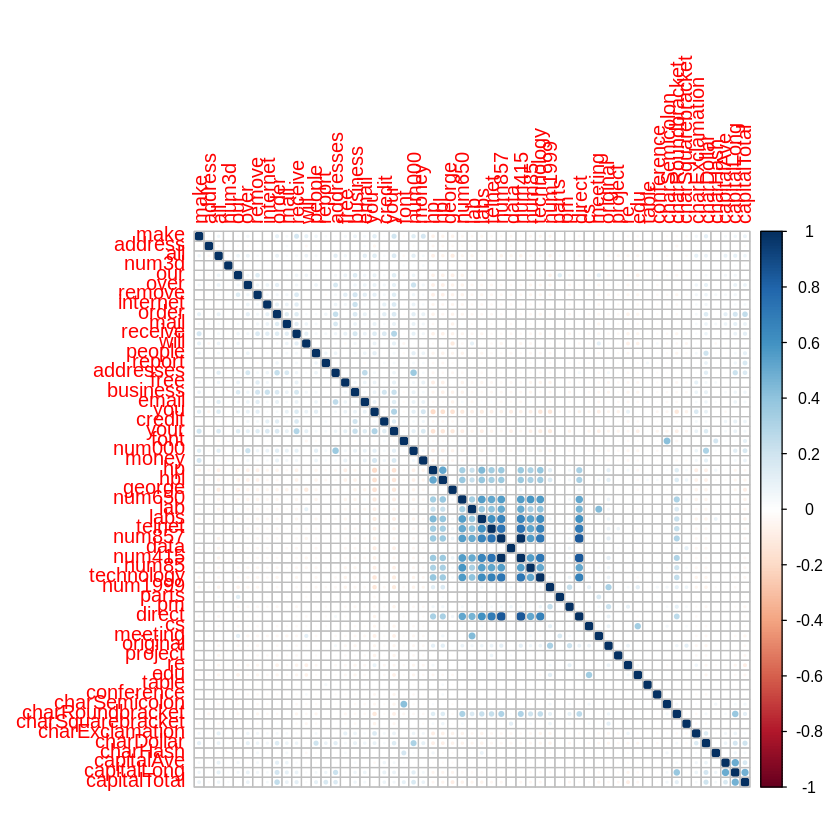

In [15]:
library("corrplot")
corrplot(cor(numerical_data), method="circle")

### Visualizacion por parejas 

* Al graficar la variable de respuesta con la frecuencia de algunas palabras podemos notar que en los correos No spam aparecen más veces ciertas palabras que en los spam, por ejemplo con la variabe `george`. Esta carácterística puede favorecer al clasificador basado en árboles.

* Al graficar variables con un coeficiente de correlación alto podemis notar que los datos que siguen una relación suelen ser del tipo No spam. Esto me hace pensar que los datos de tipo No spam presentan una fuerte dependencia lineal en esas variables.

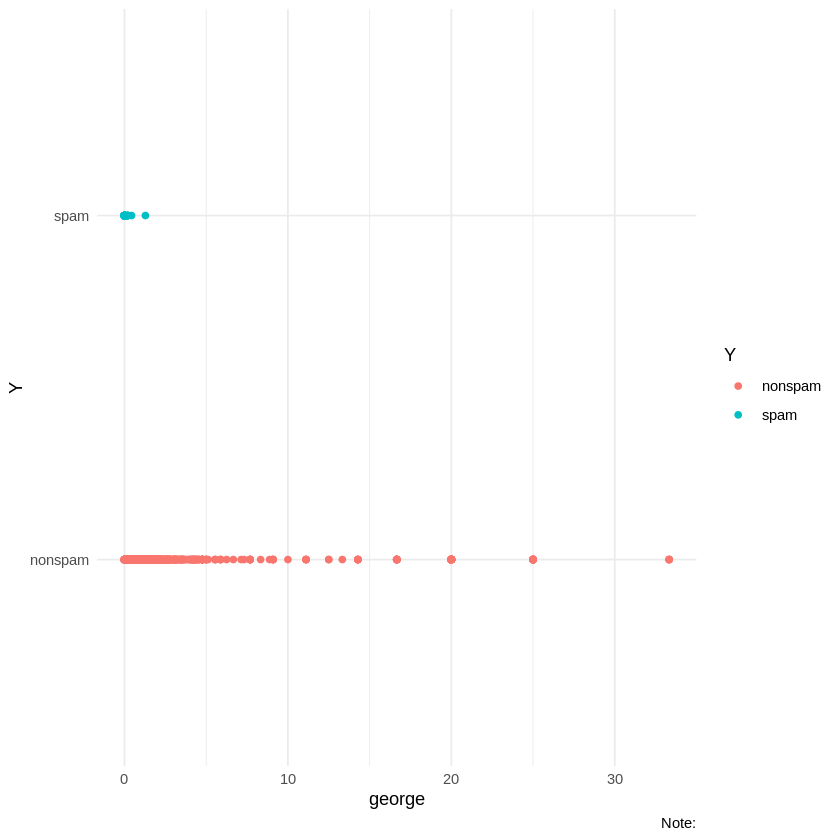

In [16]:
## George
p = ggplot(data = data, aes(x = george, y = Y)) +
    geom_point(aes(col = Y)) +
    labs(caption = "Note:") +
    theme_minimal()
p

In [17]:
subdata <- data %>% select(
    hp, hpl, num650, lab, labs, telnet, num857, 
    num415, num85, technology, direct, 
    capitalLong, capitalAve, capitalTotal,Y
)

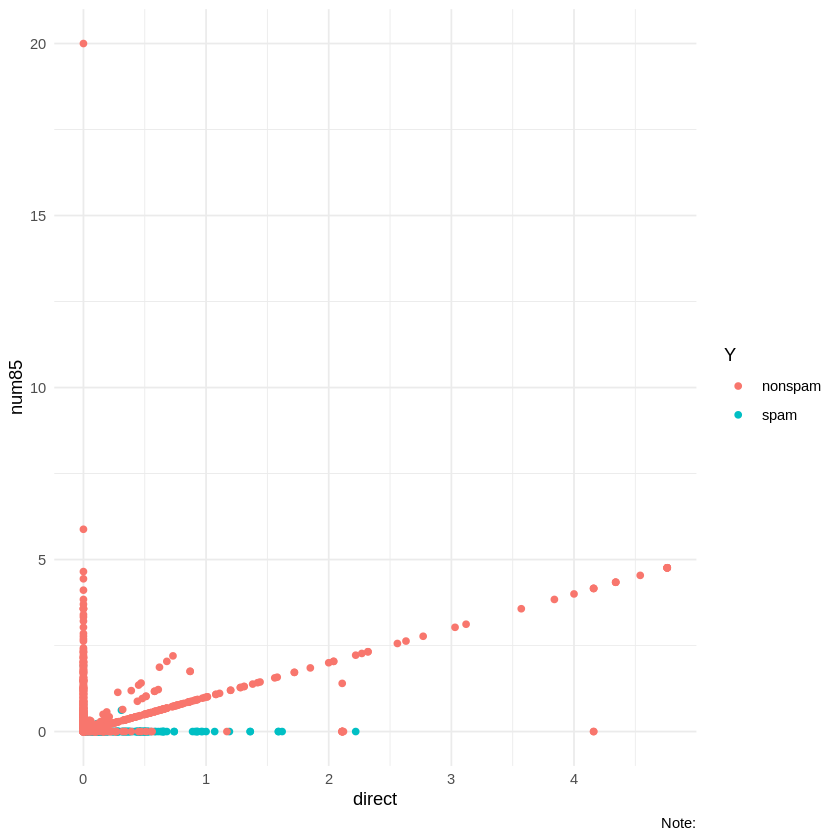

In [18]:
## First construct a scatterplot of the raw data
p = ggplot(data = subdata, aes(x = direct, y = num85)) +
    geom_point(aes(col = Y)) +
    labs(caption = "Note:") +
    theme_minimal()
p

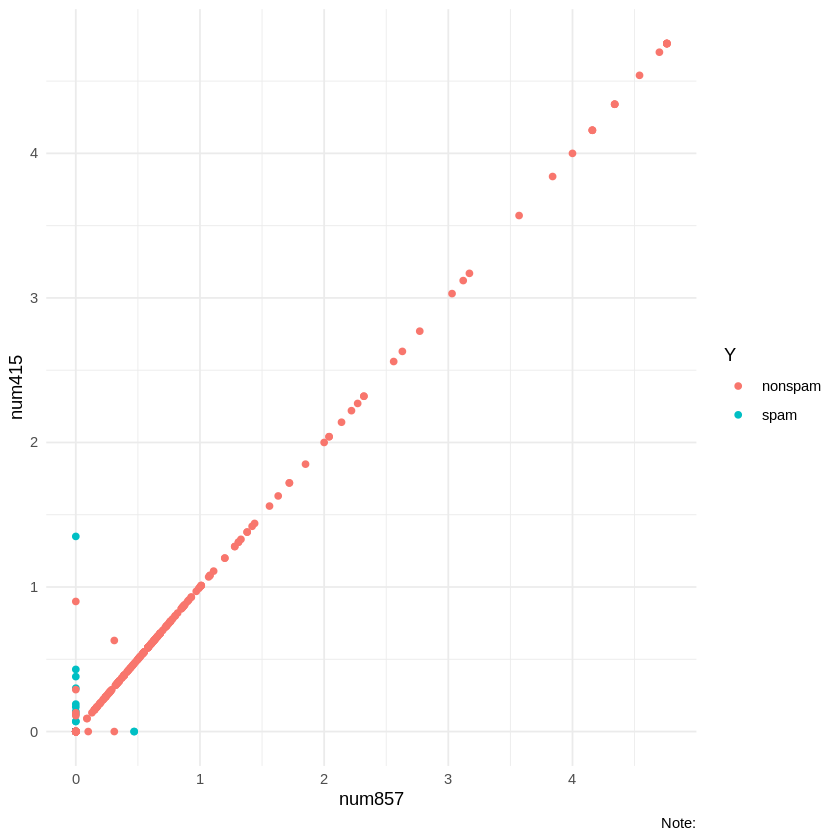

In [19]:
## First construct a scatterplot of the raw data
p = ggplot(data = subdata, aes(x = num857, y = num415)) +
    geom_point(aes(col = Y)) +
    labs(caption = "Note:") +
    theme_minimal()
p

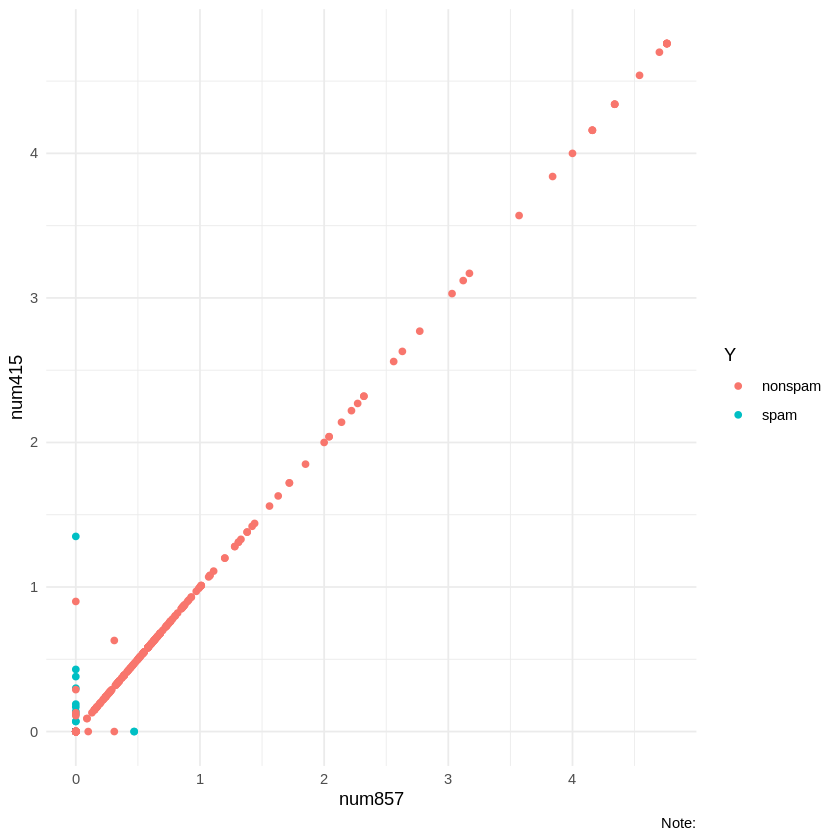

In [20]:
## First construct a scatterplot of the raw data
p = ggplot(data = subdata, aes(x = num857, y = num415)) +
    geom_point(aes(col = Y)) +
    labs(caption = "Note:") +
    theme_minimal()
p

### Visualizacion con PCA

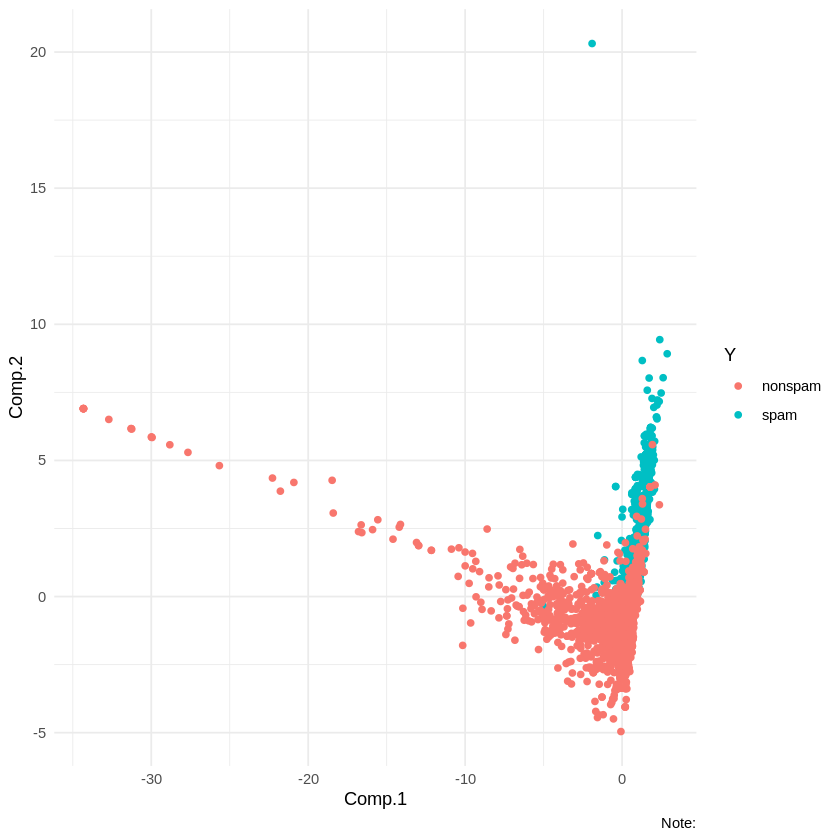

In [21]:
numerical_data <- data %>% select(-Y)
pca <- princomp(numerical_data, cor=TRUE)

pca_data <- as.data.frame(pca$scores)
pca_data$Y <- data$Y

## First construct a scatterplot of the raw data
p = ggplot(data = pca_data, aes(x = Comp.1, y = Comp.2)) +
    geom_point(aes(col = Y)) +
    labs(caption = "Note:") +
    theme_minimal()
p

# Arboles

## Funciones Auxiliares

In [22]:
library("rpart.plot") # Para mostrar arboles de descicion de rpart
library("plotmo") # Para mostrar particion del planoTree
library("rpart") # Para arboles de descicion (rpart function)
library("caret") # Para validacion cruzada

Loading required package: rpart

Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [23]:
precisionDecisionTree <- function(train, folds, alpha )
{
    # Dado un alpha, calculamos la presicion para T(alpha)
    cvDecisionTree <- lapply(folds, function(x){
        
        # x es conjunto de pruba y folds menos x es el conjunto de entrenamiento         
        training_fold <- train[-x, ] # folds menos elementos de x
        test_fold     <- train[ x, ] # elementos de x

        training_fold$Y <- as.factor(training_fold$Y)
        test_fold$Y <- as.factor(test_fold$Y)
             
        set.seed(1234)
        # Creamos un arbol T(alpha)
        clasificador <- rpart(Y ~ ., data = training_fold, cp = alpha)
        
        # cm es la matriz de confunsion, donde filas representan clase verdadera
        # y la columna la clase en la que se clasifico usando el arbol
        # Celda(i,j) contiene la cantidad de clase i, que fue clasificado como j
        y_pred <- predict(clasificador, newdata = test_fold, type = 'class')
        cm     <- table(test_fold$Y, y_pred)
        
        # Calculamos % de aciertos, es decir, la precicion del modelo. La matriz
        # cm es de 2x2 pues exusten 2 clases.
        hits  = cm[1,1] + cm[2,2]
        total = sum(cm)
        
        precision <- hits / total
        
        return(precision)
    })
    
    # Retornamos el promedio de los k modelos entrenados
    return (mean(as.numeric(cvDecisionTree)))
}

In [24]:
get_tree <- function(train, k, n = 100)
{
    Alphas = linspace(0.0, 1.0, n) # Espacio de busqueda de alpha
    max_precision = 0.0 # La presision esta acotada por 0.0
    alpha_optimal = 0.0 # Alpha = 0.0 genera el arbol maximo (Arbol saturado)
    
    # Particionamos el conjunto de entrenamiento en 10 para validacion cruzada
    set.seed(1234)
    folds <- createFolds(train$Y, k = k)# Ademas estan "balanceados"
    
    # Repetimos validacion cruzada para todos los arboles usados como modelos.
    # Nos quedamos con arbol con mayor precision. Basta guardar alpha*.
    print("(Alpha, presicion)")
    for(alpha in Alphas)
    {
        precision <- precisionDecisionTree(train, folds, alpha) 
        print(c(alpha,precision))
        # Alphas se supone ordenados ascendentemente y 
        # buscamos el mayor alpha con mayor precision (Por esto <= en vez de <)
        if( max_precision <= precision )
        {
            max_precision = precision
            alpha_optimal = alpha
        }
    }
    
    return (alpha_optimal)
}

In [25]:
tree_model <- function(train, test, k, n = 100)
{
    print("Arboles")
    # T(alpha) es creciente y luego decreciente, 
    # entonces buscamos alpha que maximiza
    alpha = get_tree(train, k, n)
    print("Alpha optimo")
    print(alpha)
    # Clasificador con alpha optimo encontrado
    clasificador <- rpart(Y ~ ., data = train, cp = alpha)
    
    pred_valid_DT <- predict(clasificador, newdata = test, type = 'class')
    matrizConfusion <- table(test$Y, pred_valid_DT)
    
    hits  = matrizConfusion[1,1] + matrizConfusion[2,2]
    total = sum(matrizConfusion)
    
    precision <- hits / total
    
    print("Precision del modelo:")
    print(precision)

    return (alpha)
}

## Selección de modelo

Para este ejercicio se particionó la muestra en dos partes para validación cruzada, tomando un 75\% como el conjunto de entrenamiento/prueba y la parte restante como el conjunto de validación. 
    
El conjutno de prueba se volvió a particionar en $k = 10$. Buscamos un $\alpha \geq 0$ que nos induzca un arbol que otorgue un poder de predicción bueno y además no tenga una gran cantidad de nodos hoja. 

A continuación se presentan los resultados obtenidos en el siguiente orden:

* Precisión promedio obtenida con árboles generados con diferentes parámetros $\alpha$. 
* Precision en conjunto de prueba del modelo elegido.
* Visualizacion del arbol de desición.

In [26]:
library("parttree")
library("pracma")


Attaching package: ‘pracma’


The following object is masked from ‘package:purrr’:

    cross


The following objects are masked from ‘package:kernlab’:

    cross, eig, size




In [27]:
# Encontramos alpha optima. Dividimos el intervalo 
# [0,1] en n = 100 para. 

# El conjunto de entrenamiento se divide en k =  5 
# para validacion cruzada.PCA

alpha_optim <- tree_model(train, test, k = 10, n = 10)

[1] "Arboles"
[1] "(Alpha, presicion)"
[1] 0.0000000 0.9098841
[1] 0.1111111 0.8229197
[1] 0.2222222 0.7829557
[1] 0.3333333 0.7829557
[1] 0.4444444 0.7829557
[1] 0.5555556 0.6079404
[1] 0.6666667 0.6079404
[1] 0.7777778 0.6079404
[1] 0.8888889 0.6079404
[1] 1.0000000 0.6079404
[1] "Alpha optimo"
[1] 0
[1] "Precision del modelo:"
[1] 0.9243478


Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


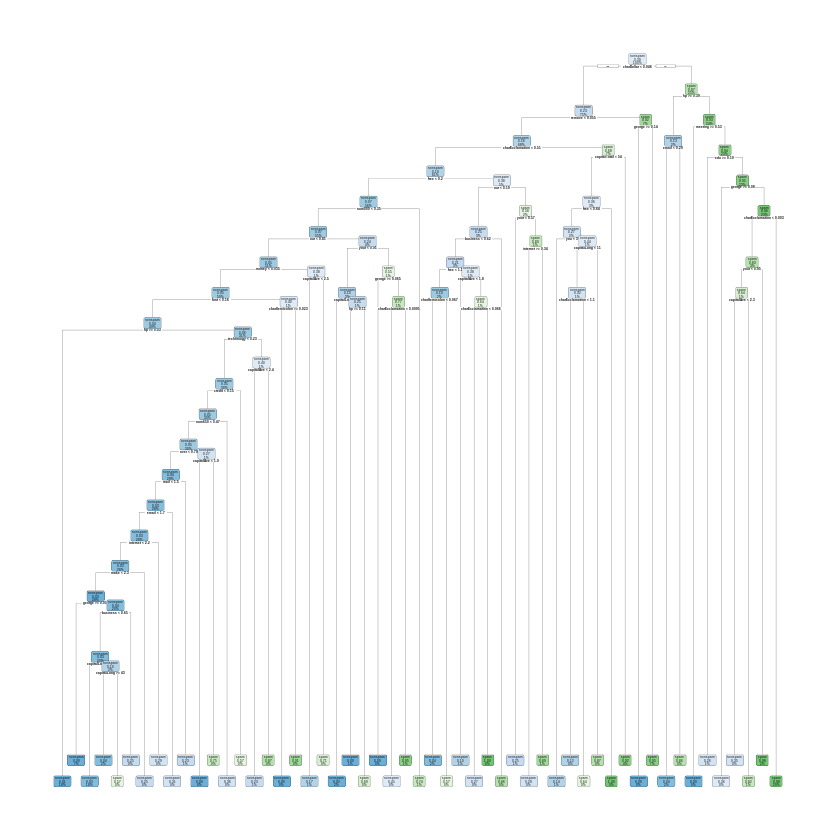

In [28]:
## Fit a decision tree using the same variables as the above plot
tree = rpart(Y ~ ., data = train, cp = alpha_optim)
rpart.plot(tree)

## Observaciones

El arbol seleccionado logra una precisión de $92\%$ en el conjunto de prueba. Podemos notar que se necesita un valor $\alpha$ bajo (en este caso $\alpha = 0$) con una profundidad mayor a 20. Esto se debe a la cantidad de variables y la estructura misma de los datos. 


# SVM

## Funciones Auxiliares

In [29]:
library(e1071)


Attaching package: ‘e1071’


The following object is masked from ‘package:pracma’:

    sigmoid




In [30]:
precisionKernelSVM <-function(train, folds, C, gamma)
{   # gamma = 1/sigma^2, C costo de no cumplir condiciones de lagrange.
    cvKernelSVM <- lapply(folds, function(x){
        training_fold <- train[-x,]
        test_fold     <- train[x,]
        
        set.seed(1234)
        clasificador <- svm(
            Y ~ ., data = training_fold, 
            type = 'C-classification', 
            kernel = 'radial',
            gamma = gamma,
            cost  = C
        )
        y_pred <- predict(clasificador, newdata = test_fold)
        cm <- table(test_fold$Y, y_pred)
        precision <- (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
        return(precision)
    })
    
    # Retornamos el promedio de los k modelos entrenados
    return (mean(as.numeric(cvKernelSVM)))
}

get_SVM <- function(training_set, C, Gammas, k )
{
    max_precision = 0.0 # La presision esta acotada por 0.0
    gamma_optimal = 100.0 
    costo_optimal = 0.0
    
    # Particionamos el conjunto de entrenamiento en subconjuntos para validacion cruzada
    set.seed(1234)
    folds <- createFolds(training_set$Y, k = k) # Ya estan balanceados
    print("(c, gamma, precision):")
    for(c in C)
    {
        for(gamma in Gammas)
        {
            precision <- precisionKernelSVM(training_set, folds, c, gamma)
            
            print(c(round(c, 2), round(gamma, 2), round(precision, 2)))
            
            if( max_precision < precision )
            {
                max_precision = precision
                gamma_optimal = gamma
                costo_optimal = c
            }
        }
    }
    
    return (c(costo_optimal, gamma_optimal))
}

svm_model <- function(training_set, test_set, k)
{
    # Uso busqueda greedy como en izenman
    C = c( 10, 100, 1000 )
    Gammas = c(0.0001, 0.001, 0.01, 0.1, 1.0, 10)

    parameters = get_SVM(training_set, C, Gammas, k)

    print("(c*, gamma*):")
    print(parameters)
    
    gamma = parameters[2]
    C = parameters[1]
    
    set.seed(1234)
    clasificador <- svm(
        Y ~ . ,data = training_set, 
        type = 'C-classification', 
        kernel = 'radial',
        gamma = gamma,
        cost  = C
    )
    
    y_pred <- predict(clasificador, newdata = test_set)
    cm <- table(test_set$Y, y_pred)
    precision <- (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
    
    print(c("Precision del modelo:",precision))

    return (c(C, gamma))
}

## Selección del modelo

Para este ejercicio se particionó la muestra en dos partes iguales para validación cruzada, tomando la primera mitad como el conjunto de entrenamiento/prueba y la otra mitad como el conjunto de validación. 
    
El conjutno de prueba se volvió a particionar en $k = 10$. Buscamos parámetros $(C, \gamma)$, donde $C$ es el parámetro de costo por violar las restricciones y el parámetro de kernel $\gamma = \frac{1}{\sigma^2}$. 
    
A continuación se presentan los resultados obtenidos en el siguiente orden:

* Precición promedio de diferentes SVM con diferentes parámetros $(C, \gamma)$. 
* Precisión en el conjunto de prueba del modelo seleccionado.

In [31]:
params <- svm_model(train, test, 10)
C_optim <- params[1]
gamma_optim <- params[2]

[1] "(c, gamma, precision):"
[1] 10.00  0.00  0.91
[1] 10.00  0.00  0.93
[1] 10.00  0.01  0.94
[1] 10.00  0.10  0.91
[1] 10.00  1.00  0.79
[1] 10.00 10.00  0.74
[1] 100.00   0.00   0.93
[1] 100.00   0.00   0.94
[1] 100.00   0.01   0.93
[1] 100.00   0.10   0.91
[1] 100.00   1.00   0.79
[1] 100.00  10.00   0.74
[1] 1000.00    0.00    0.93
[1] 1000.00    0.00    0.94
[1] 1000.00    0.01    0.91
[1] 1e+03 1e-01 9e-01
[1] 1000.00    1.00    0.78
[1] 1000.00   10.00    0.74
[1] "(c*, gamma*):"
[1] 1e+03 1e-03
[1] "Precision del modelo:" "0.93304347826087"     


In [32]:
clasificador <- svm(
    Y ~ . ,data = train, 
    type = 'C-classification', 
    kernel = 'radial',
    gamma = gamma_optim,
    cost  = C_optim
)
summary(clasificador)


Call:
svm(formula = Y ~ ., data = train, type = "C-classification", kernel = "radial", 
    gamma = gamma_optim, cost = C_optim)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1000 

Number of Support Vectors:  613

 ( 310 303 )


Number of Classes:  2 

Levels: 
 nonspam spam




## Observaciones

El clasificador basado en SVM seleccionado logra una precisión de $93\%$ en el conjunto de prueba. Para este modelo se tienen 613 vectores de soporte.

# Conclusiones

* Ambos métodos obtienen muy buenos resultados al clasificar este conjunto de datos. A mi parecer, el buen desempeño con el árbol de desición nos indica que basarse en la frecuencia de las palabras es suficiente para contruir un buen clasificador de correos Spam y No Spam. 
* El clasificador basado en SVM logra una precisión un poco mejor que el clasificador basado en un árbol de desición.
* Empíricamente podemos notar un mayor tiempo de entrenamiento para encontrar una SVM adecuada que el tiempo encontrando un árbol de clasificación.
* El clasificador basado en árbol debe hacer menos de 30 comparaciones para clasificar, mientras que el clasificador basado en SVM usa un kernel de base radial, por lo que el árbol es un clasificador más simple y con resultados buenos.